 [U-Net](https://arxiv.org/abs/1505.04597) 

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import cv2
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import backend as K
import tensorflow as tf
from datetime import datetime
import utils
from utils import DataType
import model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Set some parameters
_imgWidth = 512
_imgHeight = 512
_imgChannels = 3
_trainPath = './stage1_train_fixed/'
_valPath = './extra_data/'
_testPath = './stage2_test_final/'

# Root directory of the project
_rootDir = os.getcwd()

# Directory to save logs and trained model
_modelDir = os.path.join(_rootDir, "logs")


_seed = 42
_batchSize = 8
_batchSizeGenerator = 1
_validationSplit = 0.1
_epochs = 50

#train_ids = next(os.walk(_trainPath))[1]
#_augmentedImagesNum = 2*len(train_ids)
_augmentedImagesNum = 100

# Get the data

In [53]:
train_ids, X_train, Y_train = utils.load_dataset(_trainPath, _imgWidth, _imgHeight, _imgChannels, datasetType = DataType.trainData)
val_ids, X_val, Y_val = utils.load_dataset(_valPath, _imgWidth, _imgHeight, _imgChannels, datasetType=DataType.valData)
test_ids, X_test, sizes_test = utils.load_dataset(_testPath, _imgWidth, _imgHeight, _imgChannels, datasetType=DataType.testData)

trying to load the numpy arrays from binary files
Done!
trying to load the numpy arrays from binary files
Done!
trying to load the numpy arrays from binary files
Done!



Let's see if things look all right by drawing some random images and their associated masks.


(512, 512, 3)


(512, 512, 1)


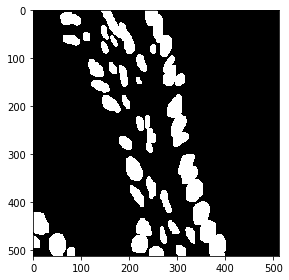

(512, 512, 3)


(512, 512, 1)


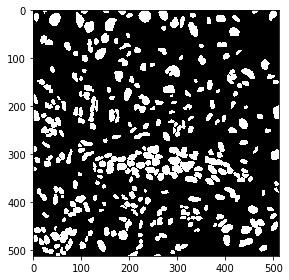

In [49]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
print(X_train[ix].shape)
#print(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
print(Y_train[ix].shape)
#print(Y_train[ix])
plt.show()


# Check if validation data looks all right
ix = random.randint(0, len(val_ids))
imshow(X_val[ix])
print(X_val[ix].shape)
plt.show()
imshow(np.squeeze(Y_val[ix]))
print(Y_val[ix].shape)
plt.show()

# Augmentation

In [43]:
###augment training images and corresponding masks with keras' ImageDataGenerator class
   
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

trainImageDatagen = ImageDataGenerator(**trainDataGenArgs)
trainMaskDatagen = ImageDataGenerator(**trainDataGenArgs)
trainImageDatagen.fit(X_train, seed = _seed)
trainMaskDatagen.fit(Y_train, seed = _seed)
trainImageGenerator = trainImageDatagen.flow(X_train, batch_size=_batchSizeGenerator, shuffle=True, seed=_seed, save_to_dir=None)
trainMaskGenerator = trainMaskDatagen.flow(Y_train, batch_size=_batchSizeGenerator, shuffle=True, seed=_seed, save_to_dir=None)
#combine generators into one which yields image and masks
trainGenerator = zip(trainImageGenerator, trainMaskGenerator)

In [47]:
###Get the images and masks out of the generator and save them in lists
images = np.zeros((_augmentedImagesNum, _imgHeight, _imgWidth, _imgChannels), dtype=np.uint8)
masks = np.zeros((_augmentedImagesNum, _imgHeight, _imgWidth, 1), dtype=np.bool)

c = 0

for x, y in tqdm(trainGenerator, total=_augmentedImagesNum-1):    
    images[c] = np.squeeze(x)
    #plt.imshow(images[c])
    #print(images[c].shape)
    #print(type(images[c]))
    #print(images[c])    
    #plt.show()
    
    m = np.squeeze(y, axis=0)
    #print(m)
    for i in range(0, m.shape[0]):
        for j in range(0, m.shape[1]):
            if m[i][j] <= 0:
                m[i][j] = 0.
            else:
                m[i][j] = 255.
    masks[c] = m
    #print(m)
    #print(masks[c])
    #plt.imshow(np.squeeze(masks[c]))
    #plt.show()
    c+=1
    if c>=_augmentedImagesNum:
        break
    

(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 3 16 16]
  [ 3 15 15]
  [ 2 15 15]
  ...
  [ 7 19 19]
  [ 7 19 19]
  [ 7 19 19]]

 [[ 4 16 16]
  [ 2 15 15]
  [ 3 15 15]
  ...
  [ 8 20 20]
  [ 8 19 19]
  [ 7 19 19]]

 [[ 4 16 16]
  [ 3 15 15]
  [ 3 15 15]
  ...
  [ 9 20 20]
  [ 7 19 19]
  [ 8 19 19]]

 ...

 [[ 4 17 17]
  [ 5 17 17]
  [ 5 17 17]
  ...
  [69 67 67]
  [72 69 69]
  [84 78 78]]

 [[ 5 17 17]
  [ 4 17 17]
  [ 5 17 17]
  ...
  [68 66 66]
  [71 68 68]
  [77 73 73]]

 [[ 4 17 17]
  [ 5 17 17]
  [ 5 17 17]
  ...
  [66 64 64]
  [70 67 67]
  [75 71 71]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 0 10 10]
  [ 0 10 10]
  [ 0 10 10]
  ...
  [ 0 10 10]
  [ 0 10 10]
  [ 0 10 10]]

 [[ 0 10 10]
  [ 4 12 12]
  [ 3 12 12]
  ...
  [ 3 11 11]
  [ 2 11 11]
  [ 0 10 10]]

 [[ 0 10 10]
  [ 5 13 13]
  [ 4 12 12]
  ...
  [ 4 12 12]
  [ 3 11 11]
  [ 0 10 10]]

 ...

 [[ 1 10 10]
  [ 6 13 13]
  [ 6 13 13]
  ...
  [ 6 13 13]
  [ 5 13 13]
  [ 0 10 10]]

 [[ 1 11 11]
  [ 7 14 14]
  [ 6 13 13]
  ...
  [ 5 1

(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 58 129 132]
  [113 158 161]
  [117 157 159]
  ...
  [120 165 165]
  [122 164 166]
  [ 69 133 135]]

 [[135 172 175]
  [209 211 214]
  [214 209 212]
  ...
  [216 221 220]
  [220 219 221]
  [150 177 180]]

 [[137 172 172]
  [212 210 212]
  [217 208 211]
  ...
  [214 221 221]
  [222 219 222]
  [153 176 181]]

 ...

 [[144 179 179]
  [221 220 221]
  [227 218 222]
  ...
  [173 176 219]
  [167 161 213]
  [101 122 170]]

 [[144 179 180]
  [221 220 222]
  [227 218 222]
  ...
  [173 180 220]
  [172 166 213]
  [108 126 168]]

 [[ 66 134 135]
  [124 165 166]
  [128 164 167]
  ...
  [ 88 136 166]
  [ 89 126 160]
  [ 41  96 126]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 4  5  5]
  [ 6  5  5]
  [ 4  5  5]
  ...
  [14  7  7]
  [13  7  7]
  [ 7  5  5]]

 [[ 8  5  5]
  [ 9  6  6]
  [ 8  6  6]
  ...
  [17  8  8]
  [17  8  8]
  [11  6  6]]

 [[ 7  5  5]
  [10  6  6]
  [ 8  6  6]
  ...
  [14  7  7]
  [15  7  7]
  [10  6  6]]

 ...

 [[ 4  5  5]
  [ 8  6  6]
  [ 

(512, 512, 3)
<class 'numpy.ndarray'>
[[[1 2 2]
  [3 3 3]
  [3 3 3]
  ...
  [6 4 4]
  [5 3 3]
  [3 2 2]]

 [[3 2 2]
  [6 4 4]
  [6 4 4]
  ...
  [9 5 5]
  [9 5 5]
  [5 3 3]]

 [[3 2 2]
  [6 4 4]
  [6 4 4]
  ...
  [8 4 4]
  [9 5 5]
  [6 4 4]]

 ...

 [[4 3 3]
  [7 4 4]
  [8 4 4]
  ...
  [6 4 4]
  [6 4 4]
  [4 3 3]]

 [[5 3 3]
  [8 4 4]
  [8 4 4]
  ...
  [6 4 4]
  [7 4 4]
  [5 3 3]]

 [[3 2 2]
  [5 3 3]
  [5 3 3]
  ...
  [4 3 3]
  [5 3 3]
  [3 2 2]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 0 11 11]
  [ 0 11 11]
  [ 0 11 11]
  ...
  [ 0 11 11]
  [ 0 11 11]
  [ 0 11 11]]

 [[ 0 11 11]
  [ 1 12 12]
  [ 1 12 12]
  ...
  [ 4 15 15]
  [ 4 15 15]
  [ 0 11 11]]

 [[ 0 11 11]
  [ 2 12 12]
  [ 1 12 12]
  ...
  [ 4 15 15]
  [ 4 15 15]
  [ 0 11 11]]

 ...

 [[ 0 11 11]
  [ 1 12 12]
  [ 3 13 13]
  ...
  [47 56 56]
  [48 57 57]
  [33 43 43]]

 [[ 0 11 11]
  [ 2 12 12]
  [ 2 13 13]
  ...
  [48 57 57]
  [48 57 57]
  [33 43 43]]

 [[ 0 11 11]
  [ 0 11 11]
  [ 0 11 11]
  ...
  [33 42 42]
  [33 43 43]
  [

(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 5 16 16]
  [ 4 16 16]
  [ 4 16 16]
  ...
  [62 65 65]
  [42 48 48]
  [24 33 33]]

 [[ 3 15 15]
  [ 4 16 16]
  [ 4 16 16]
  ...
  [65 68 68]
  [43 49 49]
  [23 32 32]]

 [[ 4 16 16]
  [ 4 15 15]
  [ 4 16 16]
  ...
  [67 70 70]
  [43 49 49]
  [24 32 32]]

 ...

 [[ 4 16 16]
  [ 5 16 16]
  [ 5 16 16]
  ...
  [ 3 14 14]
  [ 2 14 14]
  [ 2 14 14]]

 [[ 4 16 16]
  [ 5 16 16]
  [ 4 16 16]
  ...
  [ 2 14 14]
  [ 2 14 14]
  [ 2 14 14]]

 [[ 4 15 15]
  [ 4 15 15]
  [ 4 16 16]
  ...
  [ 1 13 13]
  [ 2 14 14]
  [ 2 14 14]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[  6   2   2]
  [  9   3   3]
  [  8   3   3]
  ...
  [118  19  19]
  [117  19  19]
  [ 95  15  15]]

 [[  9   3   3]
  [ 13   4   4]
  [ 11   3   3]
  ...
  [129  20  20]
  [126  20  20]
  [104  17  17]]

 [[  8   3   3]
  [ 11   3   3]
  [ 10   3   3]
  ...
  [120  19  19]
  [117  19  19]
  [ 98  16  16]]

 ...

 [[ 15   4   4]
  [ 19   4   4]
  [ 19   4   4]
  ...
  [158  25  25]
  [158  25  25

(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 0 10 10]
  [ 0 10 10]
  [ 0 10 10]
  ...
  [ 0 10 10]
  [ 0 10 10]
  [ 0 10 10]]

 [[ 0 10 10]
  [ 2 12 12]
  [ 2 12 12]
  ...
  [ 4 14 14]
  [ 3 13 13]
  [ 0 10 10]]

 [[ 0 10 10]
  [ 2 12 12]
  [ 2 12 12]
  ...
  [ 3 13 13]
  [ 3 13 13]
  [ 0 10 10]]

 ...

 [[ 0 10 10]
  [ 2 12 12]
  [ 1 11 11]
  ...
  [ 3 13 13]
  [ 4 14 14]
  [ 1 11 11]]

 [[ 0 10 10]
  [ 2 12 12]
  [ 1 11 11]
  ...
  [ 4 13 13]
  [ 4 14 14]
  [ 0 10 10]]

 [[ 0 10 10]
  [ 0 10 10]
  [ 0 10 10]
  ...
  [ 0 10 10]
  [ 0 10 10]
  [ 0 10 10]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 96 100 127]
  [133 120 156]
  [125 116 155]
  ...
  [125 151 156]
  [125 146 158]
  [ 84 115 129]]

 [[158 136 170]
  [208 164 208]
  [198 158 207]
  ...
  [197 199 207]
  [196 192 209]
  [143 152 170]]

 [[157 141 171]
  [208 170 209]
  [200 164 209]
  ...
  [197 195 206]
  [196 188 206]
  [142 149 167]]

 ...

 [[174 177 177]
  [234 218 216]
  [233 217 214]
  ...
  [176 146 161]
  [170 134 149

(512, 512, 3)
<class 'numpy.ndarray'>
[[[54 21 21]
  [68 25 25]
  [69 25 25]
  ...
  [55 21 21]
  [53 20 20]
  [44 18 18]]

 [[68 25 25]
  [83 29 29]
  [82 29 29]
  ...
  [70 25 25]
  [66 24 24]
  [53 20 20]]

 [[70 25 25]
  [83 29 29]
  [81 28 28]
  ...
  [73 26 26]
  [68 25 25]
  [54 20 20]]

 ...

 [[ 1  5  5]
  [ 3  6  6]
  [ 3  6  6]
  ...
  [ 1  5  5]
  [ 2  5  5]
  [ 0  5  5]]

 [[ 0  5  5]
  [ 3  6  6]
  [ 3  6  6]
  ...
  [ 2  5  5]
  [ 2  5  5]
  [ 0  5  5]]

 [[ 0  5  5]
  [ 0  5  5]
  [ 0  5  5]
  ...
  [ 0  5  5]
  [ 0  5  5]
  [ 0  5  5]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[100  92 123]
  [147 113 152]
  [148 113 152]
  ...
  [151 118 156]
  [151 118 155]
  [104  95 126]]

 [[168 122 165]
  [230 151 203]
  [231 150 203]
  ...
  [234 157 207]
  [234 156 207]
  [171 126 168]]

 [[169 122 166]
  [231 151 205]
  [232 150 205]
  ...
  [233 155 206]
  [233 155 206]
  [170 125 168]]

 ...

 [[171 127 168]
  [233 157 207]
  [234 158 207]
  ...
  [232 161 208]
  [234 161 208

(512, 512, 3)
<class 'numpy.ndarray'>
[[[163 149 149]
  [151 139 139]
  [140 129 129]
  ...
  [  1  11  11]
  [  2  11  11]
  [  0  10  10]]

 [[163 149 149]
  [154 142 142]
  [136 126 126]
  ...
  [  1  11  11]
  [  1  11  11]
  [  1  11  11]]

 [[164 150 150]
  [152 140 140]
  [139 128 128]
  ...
  [  1  11  11]
  [  2  11  11]
  [  1  11  11]]

 ...

 [[  3  12  12]
  [  2  12  12]
  [  2  12  12]
  ...
  [  2  11  11]
  [  2  12  12]
  [  2  12  12]]

 [[  3  12  12]
  [  2  12  12]
  [  3  12  12]
  ...
  [  2  12  12]
  [  2  12  12]
  [  2  12  12]]

 [[  3  12  12]
  [  3  12  12]
  [  3  12  12]
  ...
  [  2  12  12]
  [  2  12  12]
  [  2  12  12]]]
(512, 512, 3)
<class 'numpy.ndarray'>
[[[ 7  5  5]
  [13  5  5]
  [13  5  5]
  ...
  [13  5  5]
  [13  5  5]
  [ 7  5  5]]

 [[13  5  5]
  [20  7  7]
  [20  7  7]
  ...
  [20  7  7]
  [20  7  7]
  [13  5  5]]

 [[13  5  5]
  [19  6  6]
  [19  6  6]
  ...
  [20  7  7]
  [20  7  7]
  [14  6  6]]

 ...

 [[ 8  5  5]
  [17  6  6]
  [2

100
100
(512, 512, 3)


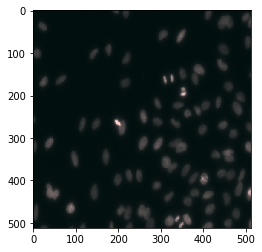

(512, 512, 1)


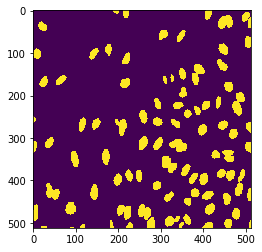

(512, 512, 3)


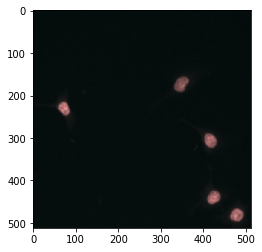

(512, 512, 1)


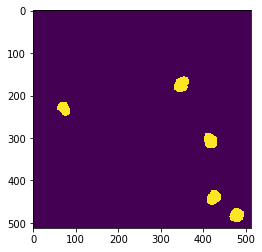

(512, 512, 3)


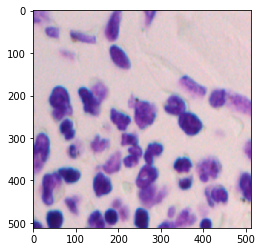

(512, 512, 1)


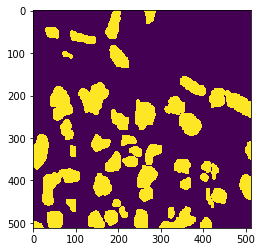

(512, 512, 3)


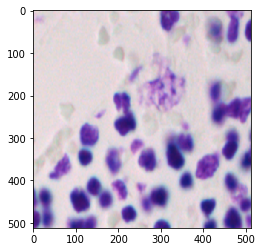

(512, 512, 1)


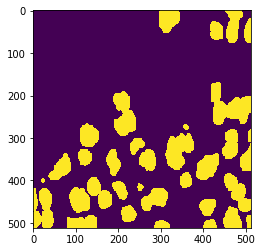

(512, 512, 3)


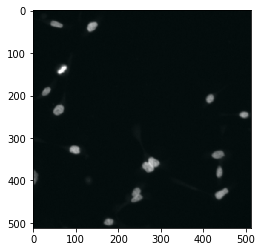

(512, 512, 1)


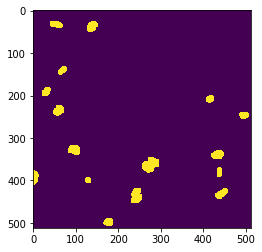

(512, 512, 3)


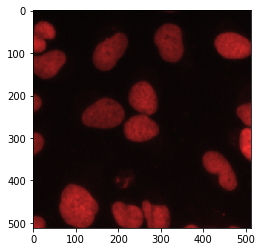

(512, 512, 1)


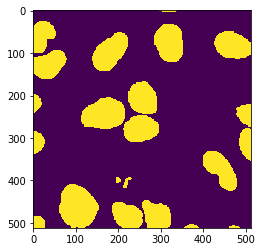

(512, 512, 3)


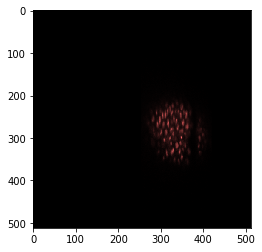

(512, 512, 1)


(512, 512, 3)


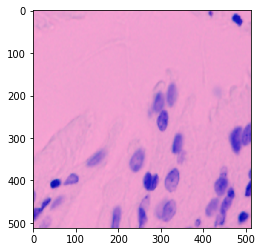

(512, 512, 1)


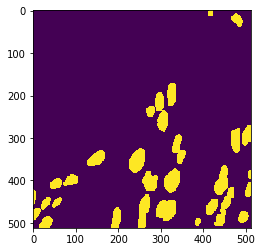

(512, 512, 3)


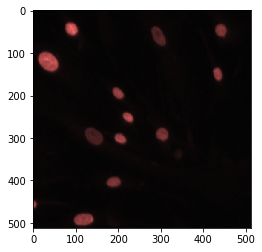

(512, 512, 1)


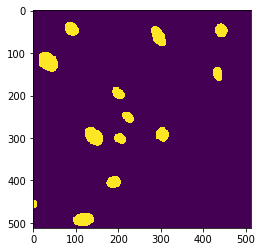

(512, 512, 3)


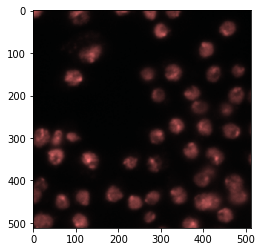

(512, 512, 1)


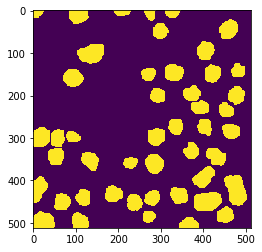

(512, 512, 3)


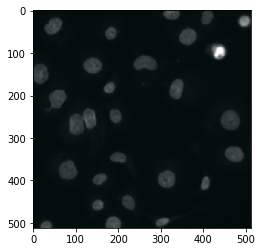

(512, 512, 1)


(512, 512, 3)


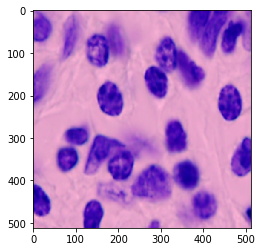

(512, 512, 1)


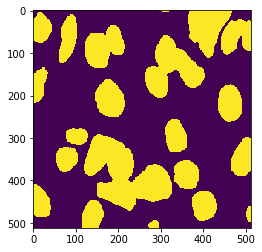

(512, 512, 3)


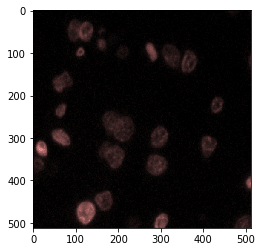

(512, 512, 1)


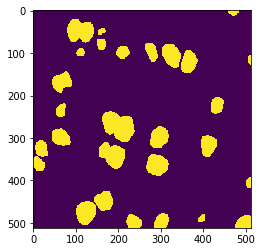

(512, 512, 3)


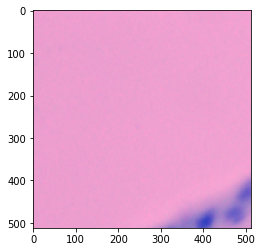

(512, 512, 1)


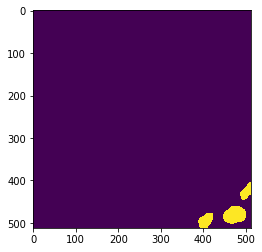

(512, 512, 3)


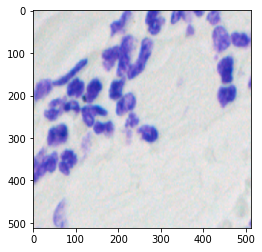

(512, 512, 1)


(512, 512, 3)


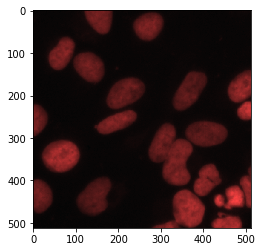

(512, 512, 1)


(512, 512, 3)


(512, 512, 1)


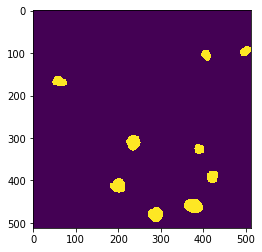

(512, 512, 3)


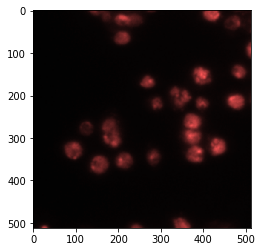

(512, 512, 1)


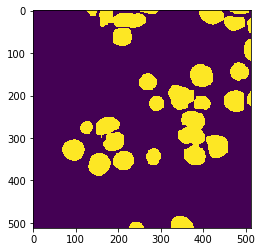

(512, 512, 3)


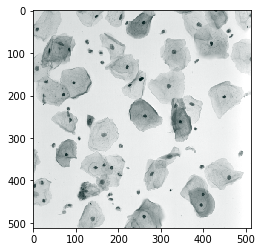

(512, 512, 1)


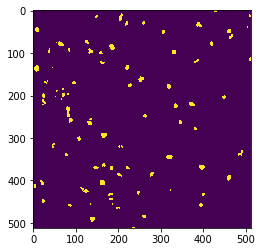

(512, 512, 3)


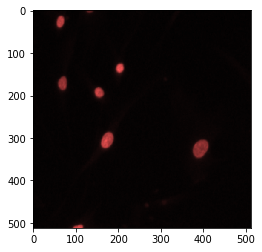

(512, 512, 1)


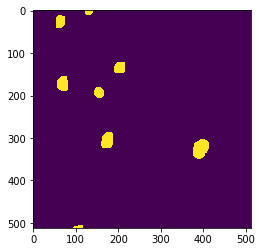

(512, 512, 3)


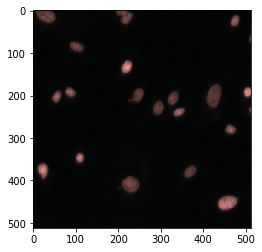

(512, 512, 1)


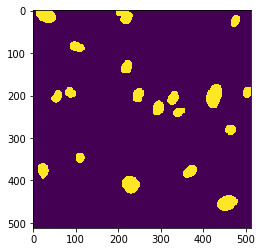

(512, 512, 3)


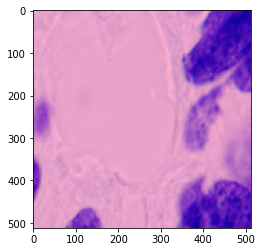

(512, 512, 1)


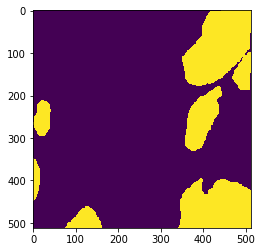

(512, 512, 3)


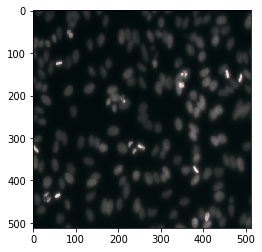

(512, 512, 1)


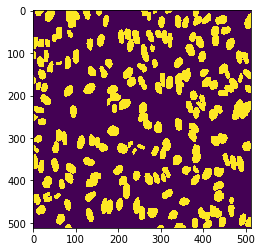

(512, 512, 3)


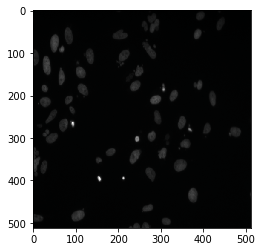

(512, 512, 1)


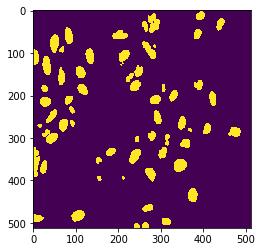

(512, 512, 3)


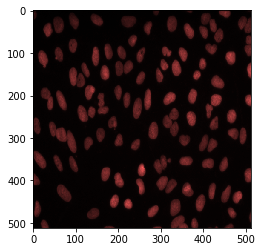

(512, 512, 1)


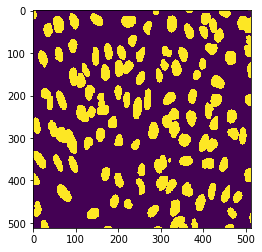

(512, 512, 3)


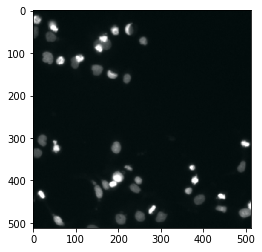

(512, 512, 1)


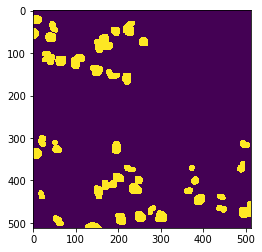

(512, 512, 3)


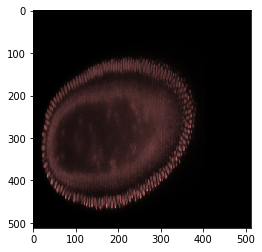

(512, 512, 1)


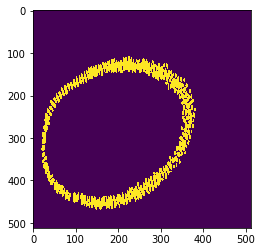

(512, 512, 3)


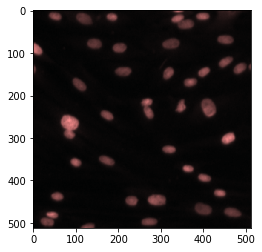

(512, 512, 1)


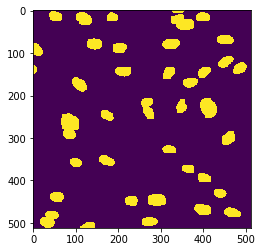

(512, 512, 3)


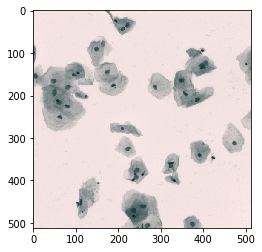

(512, 512, 1)


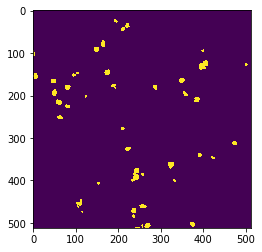

(512, 512, 3)


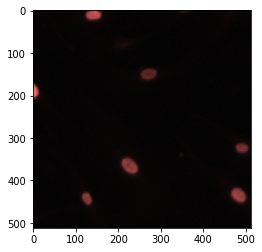

(512, 512, 1)


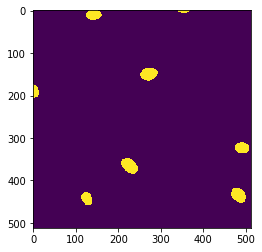

(512, 512, 3)


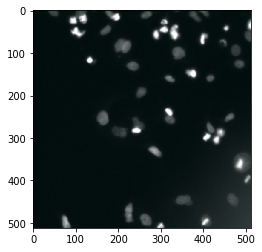

(512, 512, 1)


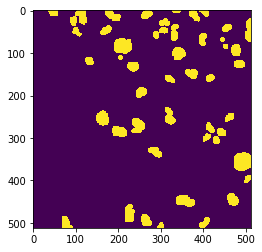

(512, 512, 3)


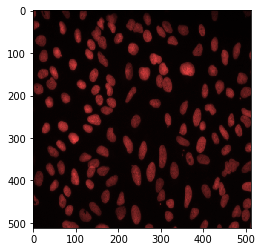

(512, 512, 1)


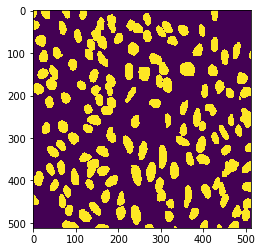

(512, 512, 3)


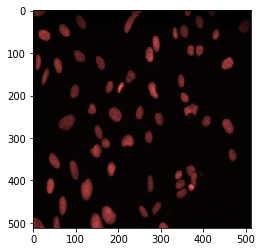

(512, 512, 1)


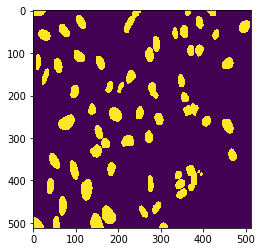

(512, 512, 3)


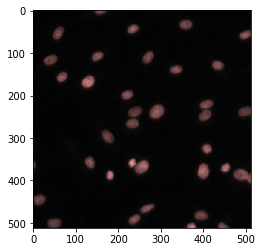

(512, 512, 1)


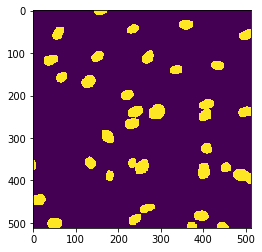

(512, 512, 3)


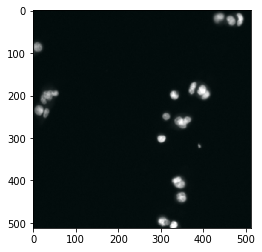

(512, 512, 1)


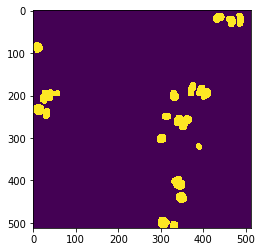

(512, 512, 3)


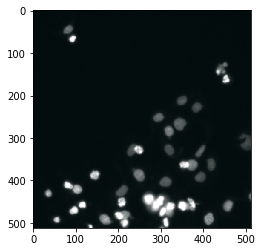

(512, 512, 1)


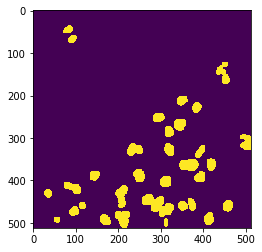

(512, 512, 3)


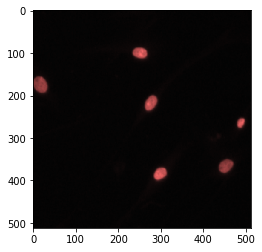

(512, 512, 1)


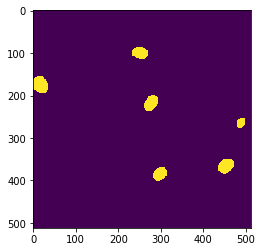

(512, 512, 3)


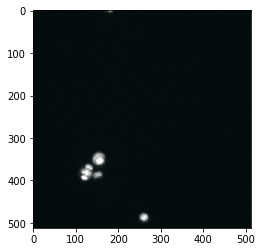

(512, 512, 1)


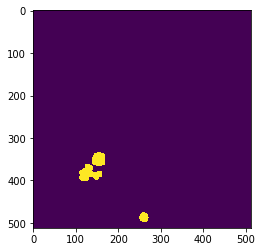

(512, 512, 3)


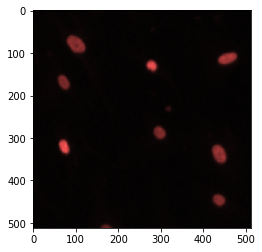

(512, 512, 1)


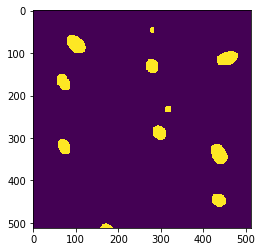

(512, 512, 3)


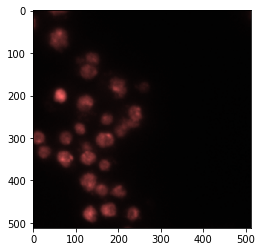

(512, 512, 1)


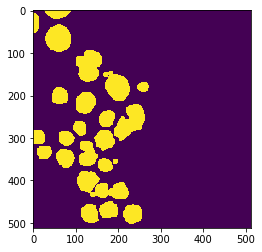

(512, 512, 3)


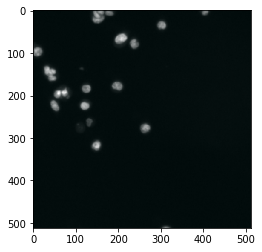

(512, 512, 1)


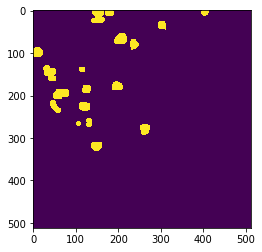

(512, 512, 3)


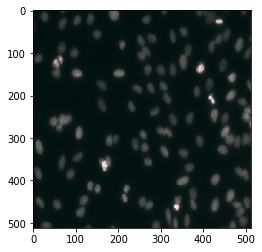

(512, 512, 1)


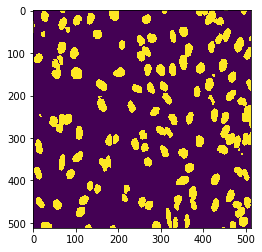

(512, 512, 3)


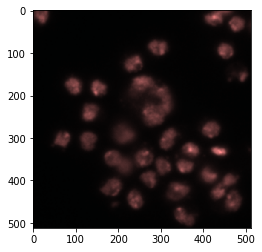

(512, 512, 1)


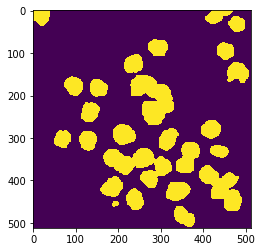

(512, 512, 3)


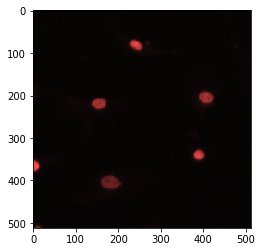

(512, 512, 1)


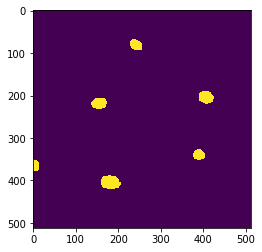

(512, 512, 3)


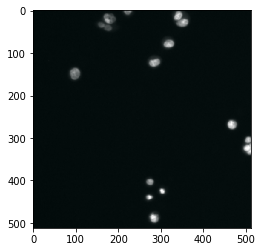

(512, 512, 1)


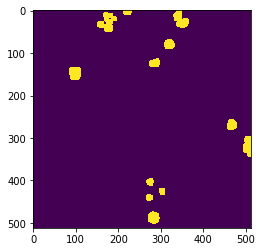

(512, 512, 3)


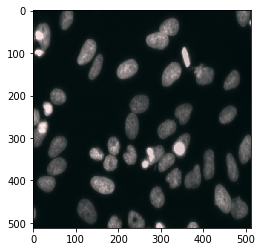

(512, 512, 1)


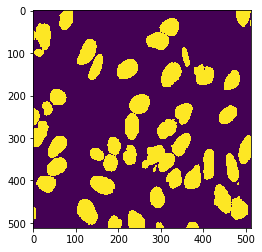

(512, 512, 3)


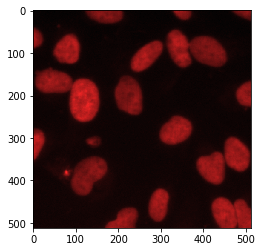

(512, 512, 1)


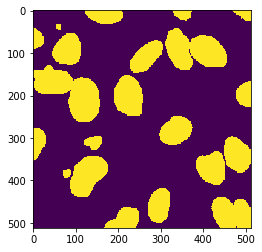

(512, 512, 3)


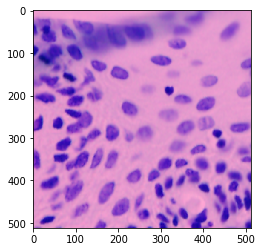

(512, 512, 1)


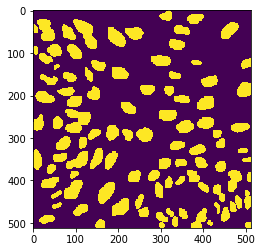

(512, 512, 3)


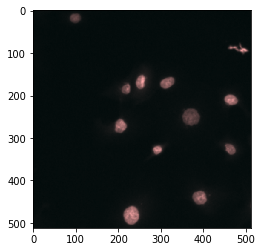

(512, 512, 1)


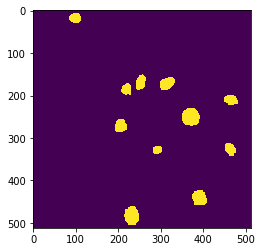

(512, 512, 3)


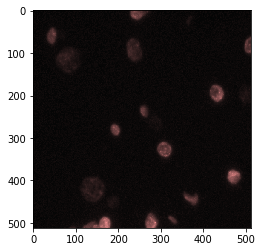

(512, 512, 1)


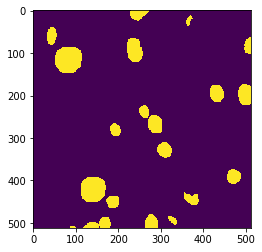

(512, 512, 3)


(512, 512, 1)


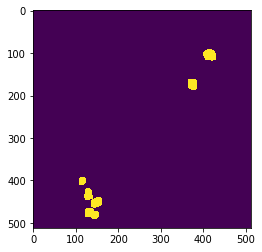

(512, 512, 3)


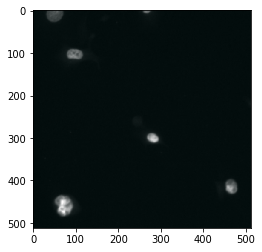

(512, 512, 1)


(512, 512, 3)


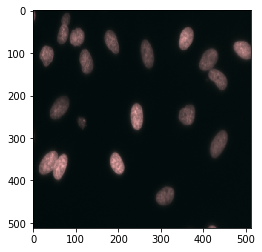

(512, 512, 1)


(512, 512, 3)


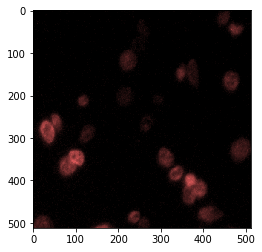

(512, 512, 1)


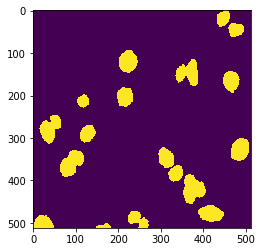

(512, 512, 3)


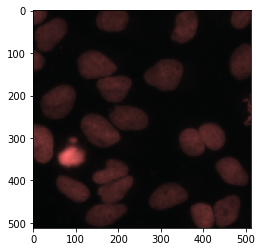

(512, 512, 1)


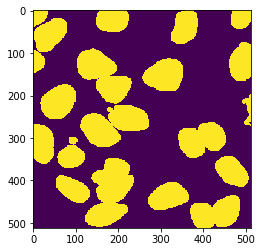

(512, 512, 3)


(512, 512, 1)


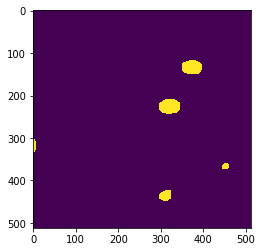

(512, 512, 3)


(512, 512, 1)


(512, 512, 3)


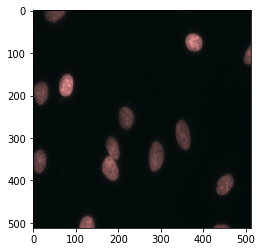

(512, 512, 1)


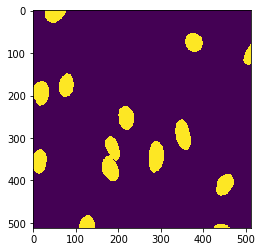

(512, 512, 3)


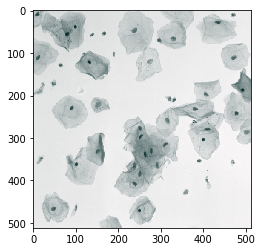

(512, 512, 1)


(512, 512, 3)


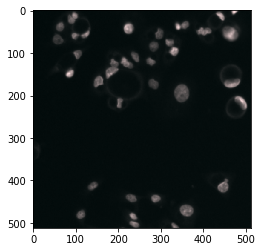

(512, 512, 1)


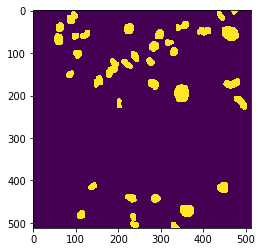

(512, 512, 3)


(512, 512, 1)


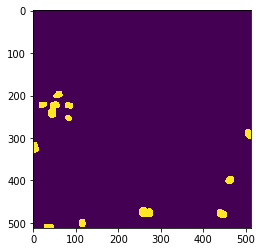

(512, 512, 3)


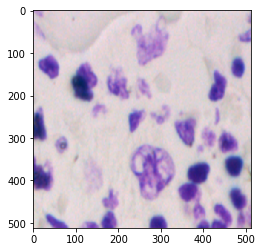

(512, 512, 1)


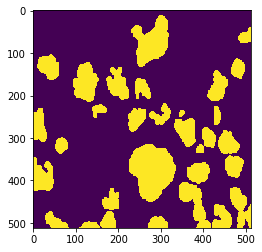

(512, 512, 3)


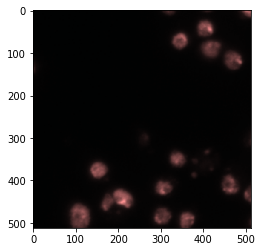

(512, 512, 1)


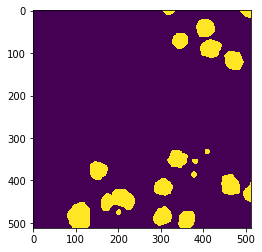

(512, 512, 3)


(512, 512, 1)


(512, 512, 3)


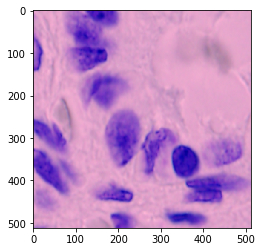

(512, 512, 1)


(512, 512, 3)


(512, 512, 1)


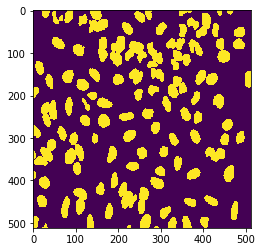

(512, 512, 3)


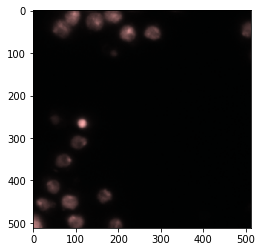

(512, 512, 1)


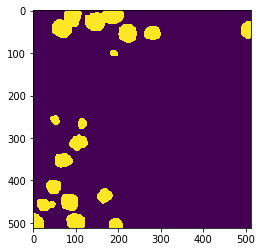

(512, 512, 3)


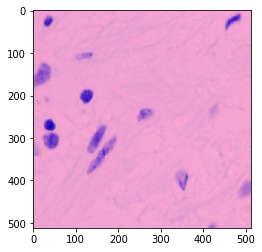

(512, 512, 1)


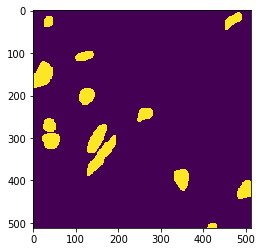

(512, 512, 3)


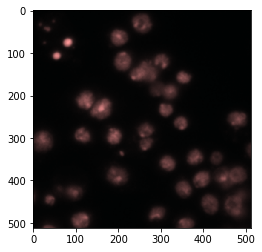

(512, 512, 1)


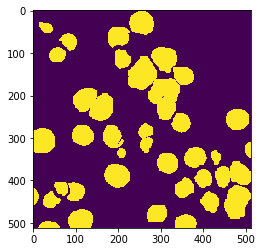

(512, 512, 3)


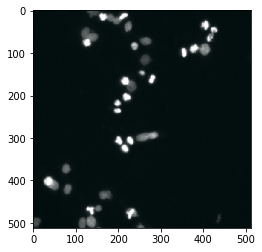

(512, 512, 1)


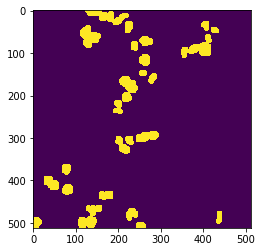

(512, 512, 3)


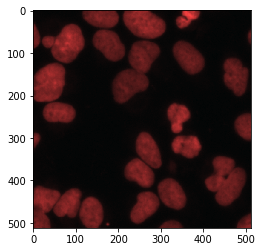

(512, 512, 1)


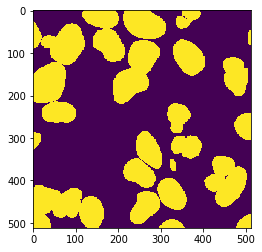

(512, 512, 3)


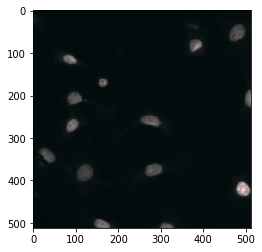

(512, 512, 1)


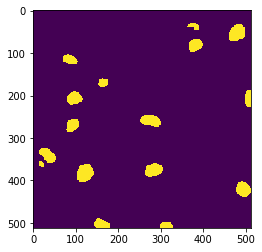

(512, 512, 3)


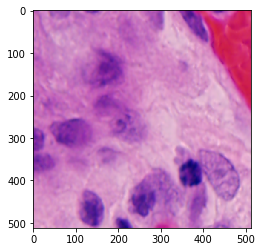

(512, 512, 1)


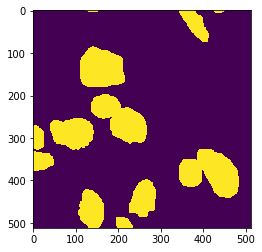

(512, 512, 3)


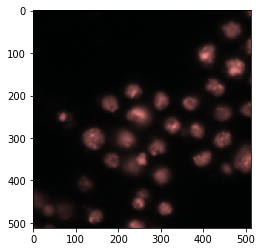

(512, 512, 1)


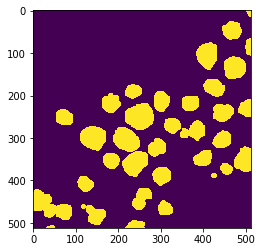

(512, 512, 3)


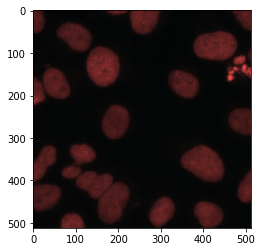

(512, 512, 1)


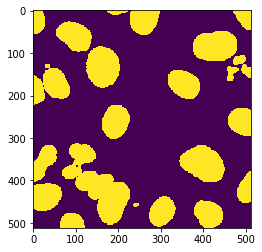

(512, 512, 3)


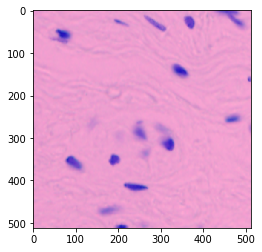

(512, 512, 1)


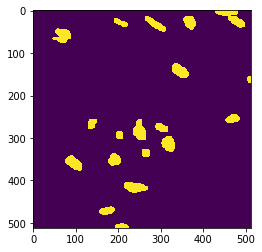

(512, 512, 3)


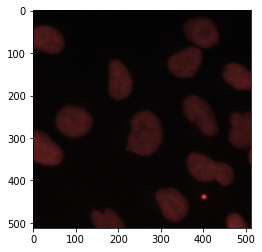

(512, 512, 1)


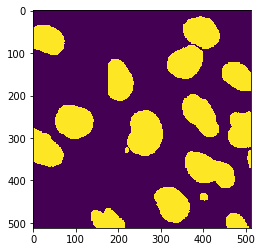

(512, 512, 3)


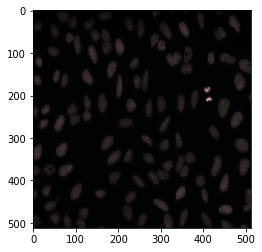

(512, 512, 1)


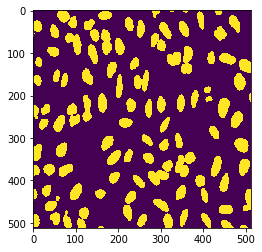

(512, 512, 3)


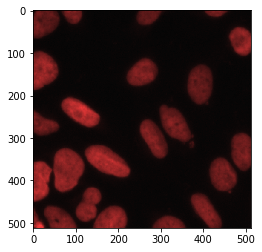

(512, 512, 1)


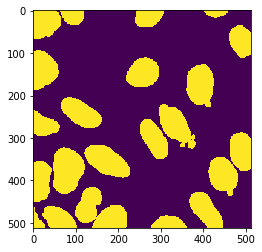

(512, 512, 3)


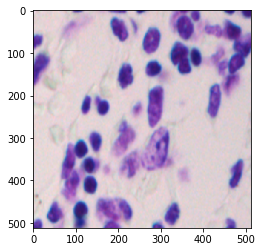

(512, 512, 1)


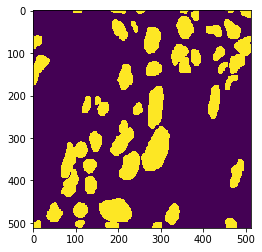

(512, 512, 3)


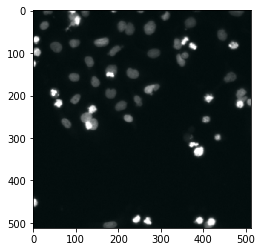

(512, 512, 1)


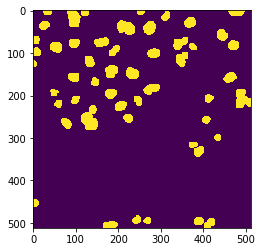

(512, 512, 3)


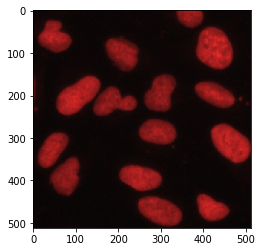

(512, 512, 1)


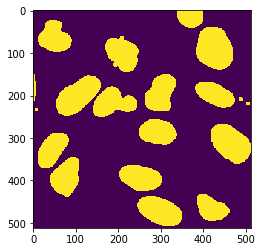

(512, 512, 3)


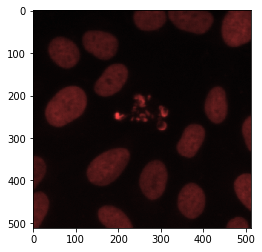

(512, 512, 1)


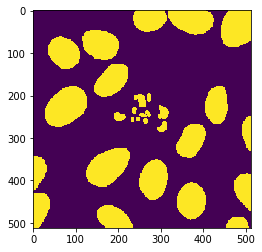

(512, 512, 3)


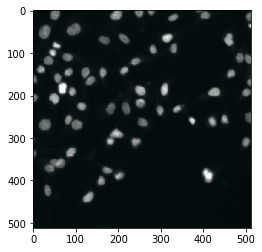

(512, 512, 1)


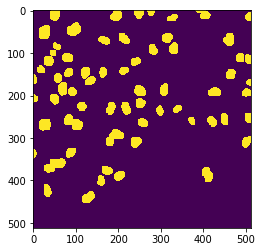

(512, 512, 3)


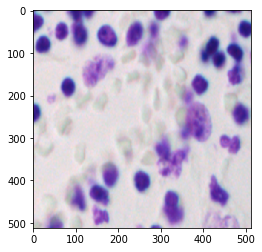

(512, 512, 1)


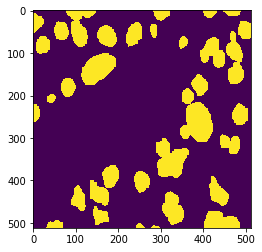

(512, 512, 3)


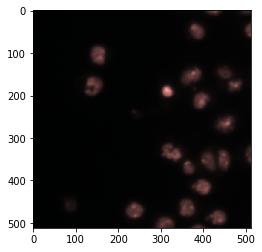

(512, 512, 1)


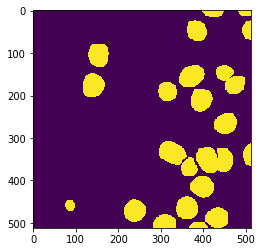

(512, 512, 3)


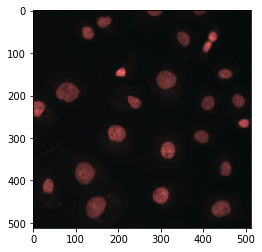

(512, 512, 1)


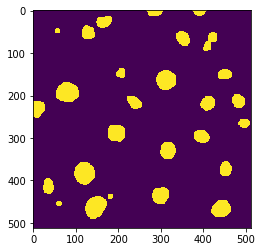

(512, 512, 3)


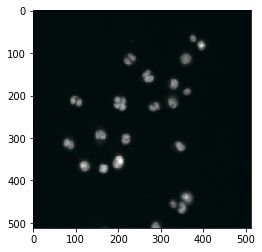

(512, 512, 1)


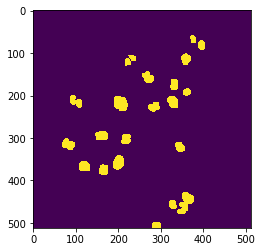

(512, 512, 3)


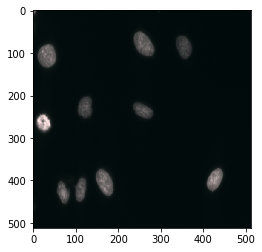

(512, 512, 1)


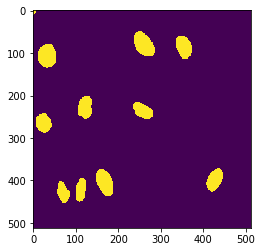

(512, 512, 3)


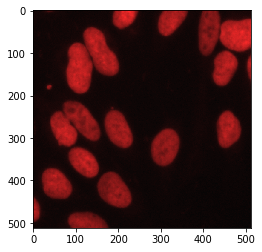

(512, 512, 1)


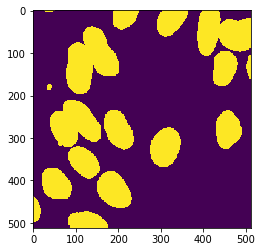

(512, 512, 3)


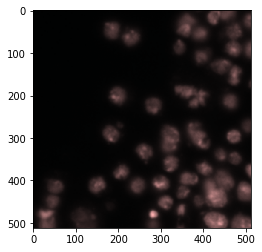

(512, 512, 1)


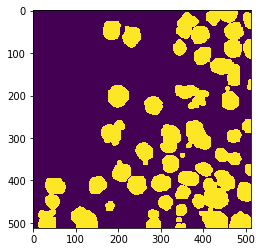

(512, 512, 3)


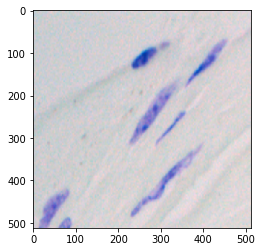

(512, 512, 1)


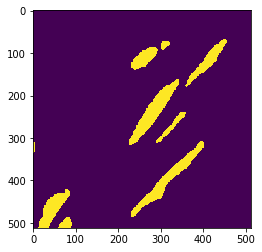

(512, 512, 3)


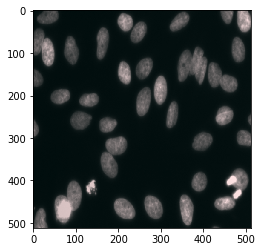

(512, 512, 1)


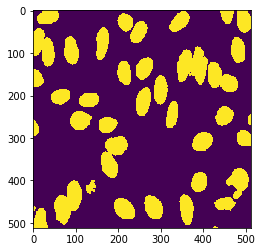

(512, 512, 3)


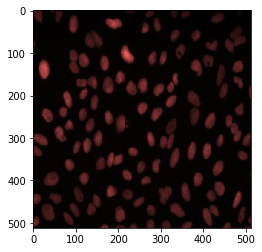

(512, 512, 1)


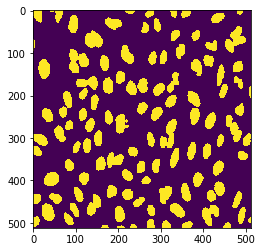

(512, 512, 3)


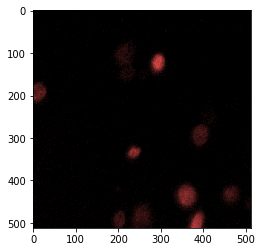

(512, 512, 1)


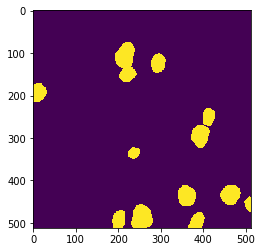

(512, 512, 3)


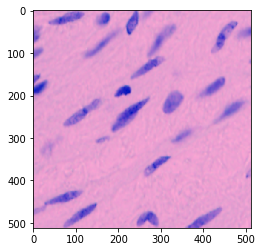

(512, 512, 1)


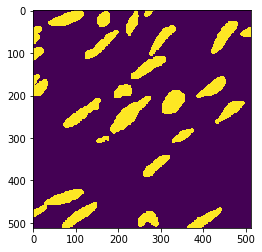

(512, 512, 3)


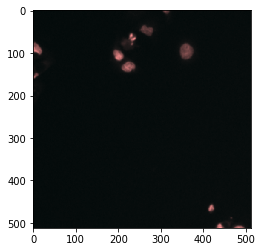

(512, 512, 1)


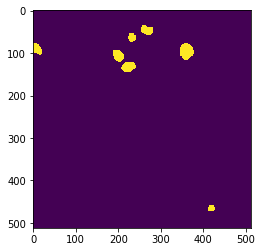

(512, 512, 3)


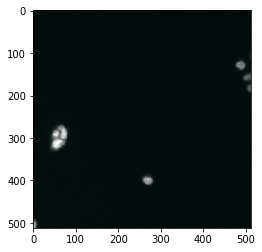

(512, 512, 1)


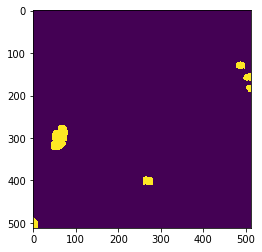

(512, 512, 3)


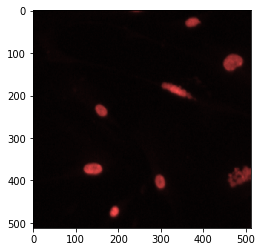

(512, 512, 1)


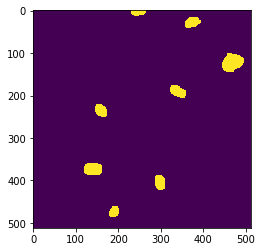

(512, 512, 3)


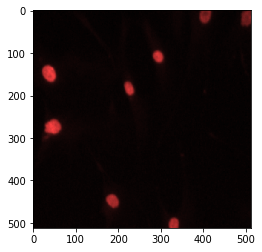

(512, 512, 1)


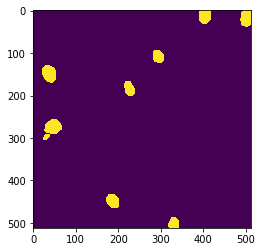

In [48]:
print(len(images))
print(len(masks))
for i in range(0, len(images)):
#for i in range(0, 50):
    im = images[i]    
    print(im.shape)
    plt.imshow(im)
    plt.show()
    
    ma = masks[i]
    print(ma.shape)
    plt.imshow(np.squeeze(ma))
    plt.show()

# Build and train neural network

In [12]:
u_net = model.build_model(_imgWidth, _imgWidth, _imgChannels)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 512, 512, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 512, 512, 8)  224         lambda_7[0][0]                   
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 512, 512, 8)  584         conv2d_115[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [13]:
model.fit_model(u_net, _modelDir, X_train, Y_train, _validationSplit, _epochs, _batchSize)

Train on 597 samples, validate on 67 samples
Epoch 1/50
597/597 [==============================] - 13s 22ms/step - loss: 0.4048 - dice_coef: 0.2838 - dice_coef_loss: 0.7162 - binary_crossentropy: 0.4048 - binary_crossentropy_with_dice_coef_loss: 1.1210 - val_loss: 0.2322 - val_dice_coef: 0.4313 - val_dice_coef_loss: 0.5687 - val_binary_crossentropy: 0.2322 - val_binary_crossentropy_with_dice_coef_loss: 0.8010

Epoch 00001: val_loss improved from inf to 0.23224, saving model to /home/Deep_Learner/work/U-Net/logs/2018-06-08 18:05:31/epoch0001-val_loss0.23.h5
Epoch 2/50
597/597 [==============================] - 9s 15ms/step - loss: 0.2219 - dice_coef: 0.4466 - dice_coef_loss: 0.5534 - binary_crossentropy: 0.2219 - binary_crossentropy_with_dice_coef_loss: 0.7753 - val_loss: 0.2073 - val_dice_coef: 0.4833 - val_dice_coef_loss: 0.5167 - val_binary_crossentropy: 0.2073 - val_binary_crossentropy_with_dice_coef_loss: 0.7240

Epoch 00002: val_loss improved from 0.23224 to 0.20728, saving model 

597/597 [==============================] - 9s 15ms/step - loss: 0.0749 - dice_coef: 0.8595 - dice_coef_loss: 0.1405 - binary_crossentropy: 0.0749 - binary_crossentropy_with_dice_coef_loss: 0.2154 - val_loss: 0.0710 - val_dice_coef: 0.8678 - val_dice_coef_loss: 0.1322 - val_binary_crossentropy: 0.0710 - val_binary_crossentropy_with_dice_coef_loss: 0.2032

Epoch 00017: val_loss improved from 0.07282 to 0.07097, saving model to /home/Deep_Learner/work/U-Net/logs/2018-06-08 18:05:31/epoch0017-val_loss0.07.h5
Epoch 18/50
597/597 [==============================] - 9s 15ms/step - loss: 0.0734 - dice_coef: 0.8609 - dice_coef_loss: 0.1391 - binary_crossentropy: 0.0734 - binary_crossentropy_with_dice_coef_loss: 0.2125 - val_loss: 0.0692 - val_dice_coef: 0.8677 - val_dice_coef_loss: 0.1323 - val_binary_crossentropy: 0.0692 - val_binary_crossentropy_with_dice_coef_loss: 0.2015

Epoch 00018: val_loss improved from 0.07097 to 0.06923, saving model to /home/Deep_Learner/work/U-Net/logs/2018-06-08 18:


Epoch 00034: val_loss did not improve
Epoch 35/50
597/597 [==============================] - 9s 16ms/step - loss: 0.0639 - dice_coef: 0.8791 - dice_coef_loss: 0.1209 - binary_crossentropy: 0.0639 - binary_crossentropy_with_dice_coef_loss: 0.1848 - val_loss: 0.0628 - val_dice_coef: 0.8791 - val_dice_coef_loss: 0.1209 - val_binary_crossentropy: 0.0628 - val_binary_crossentropy_with_dice_coef_loss: 0.1837

Epoch 00035: val_loss did not improve
Epoch 36/50
597/597 [==============================] - 9s 16ms/step - loss: 0.0645 - dice_coef: 0.8755 - dice_coef_loss: 0.1245 - binary_crossentropy: 0.0645 - binary_crossentropy_with_dice_coef_loss: 0.1890 - val_loss: 0.0635 - val_dice_coef: 0.8723 - val_dice_coef_loss: 0.1277 - val_binary_crossentropy: 0.0635 - val_binary_crossentropy_with_dice_coef_loss: 0.1912

Epoch 00036: val_loss did not improve
Epoch 37/50
597/597 [==============================] - 9s 16ms/step - loss: 0.0646 - dice_coef: 0.8736 - dice_coef_loss: 0.1264 - binary_crossentro

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [18]:
preds_train_t, preds_val_t, preds_test_upsampled = model.make_predictions('./logs/2018-06-08 18:05:31/epoch0033-val_loss0.06.h5', X_train, X_val, X_test, sizes_test)

3018/3018 [==============================] - 27s 9ms/step


/tmp/scikit-image/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


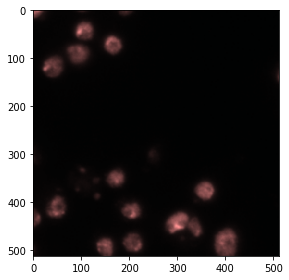

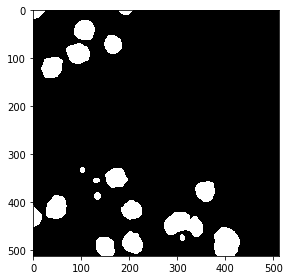

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


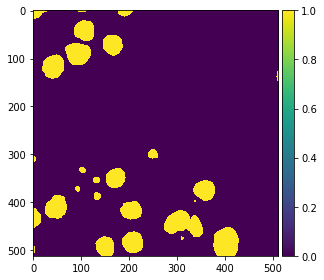

In [50]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

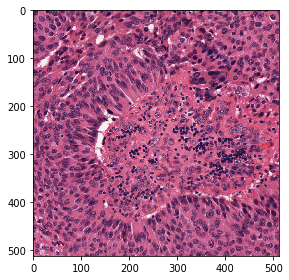

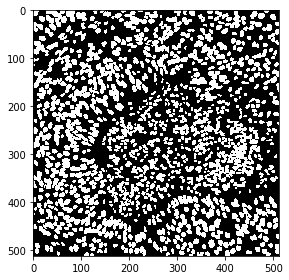

/tmp/scikit-image/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


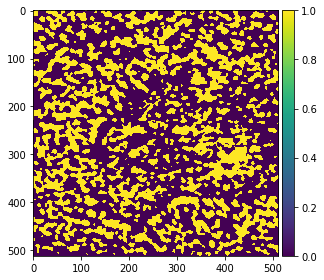

In [21]:
# Perform a sanity check on some random validation samples
"""
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
"""
ix = random.randint(0, len(preds_val_t)-1)
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(Y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

and the test data:

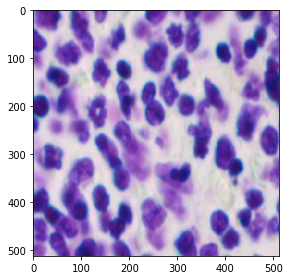

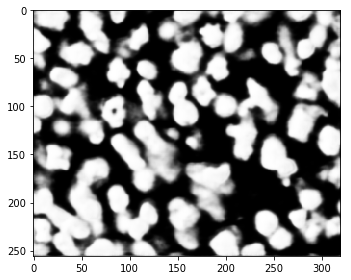

In [24]:
# Perform a sanity check on some random test sample
ix = random.randint(0, len(preds_test_upsampled))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_upsampled[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [25]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(utils.prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

IndexError: list index out of range

... and then finally create our submission!

In [37]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('./submissions/sub-dsbowl2018-U-Net_12.csv', index=False)